In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

df=pd.read_csv('creditcard.csv')
df

In [10]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
df.isnull().sum().max()

0

нет пропусков в даннхых

In [12]:
round(df['Class'].value_counts()[1]/len(df) * 100,4) 

0.1727

процент "подозрительных" операций


In [13]:

dubl = df.drop_duplicates()
len(df)-len(dubl)

1081

количество повторяющихся операций

In [14]:
round(df['Class'].value_counts()[1]/len(dubl) * 100,4)

0.1734

процент практически не изменился после удаления повторяющихся операций
данные плохо сбалансированы всего 0.17% операций являются подозрительными

Построим матрицу корреляции, посмотрим какике параметры как коррелируют

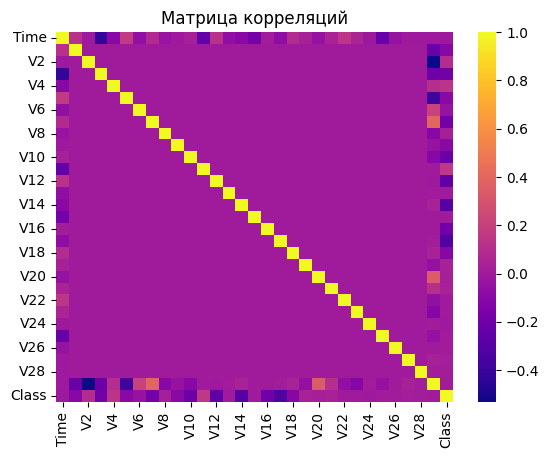

In [16]:
sns.heatmap(df.corr(), cmap='plasma')
plt.title("Матрица корреляций")
plt.show()

Можно заметить, что имеется сильная корреляция всех параметром с параметром 'Time',  а также некоторая коореляция с параметрами 'Class' и 'Amount'

Тут следуюет построить pairplotЫ для разлчиных параметров, но для всего этого добра они построятся к новому году
Поэтому ограничимся лишь некотрыми фичами, которые для обычных людей обозначают моторы) (V6, V8, V12)

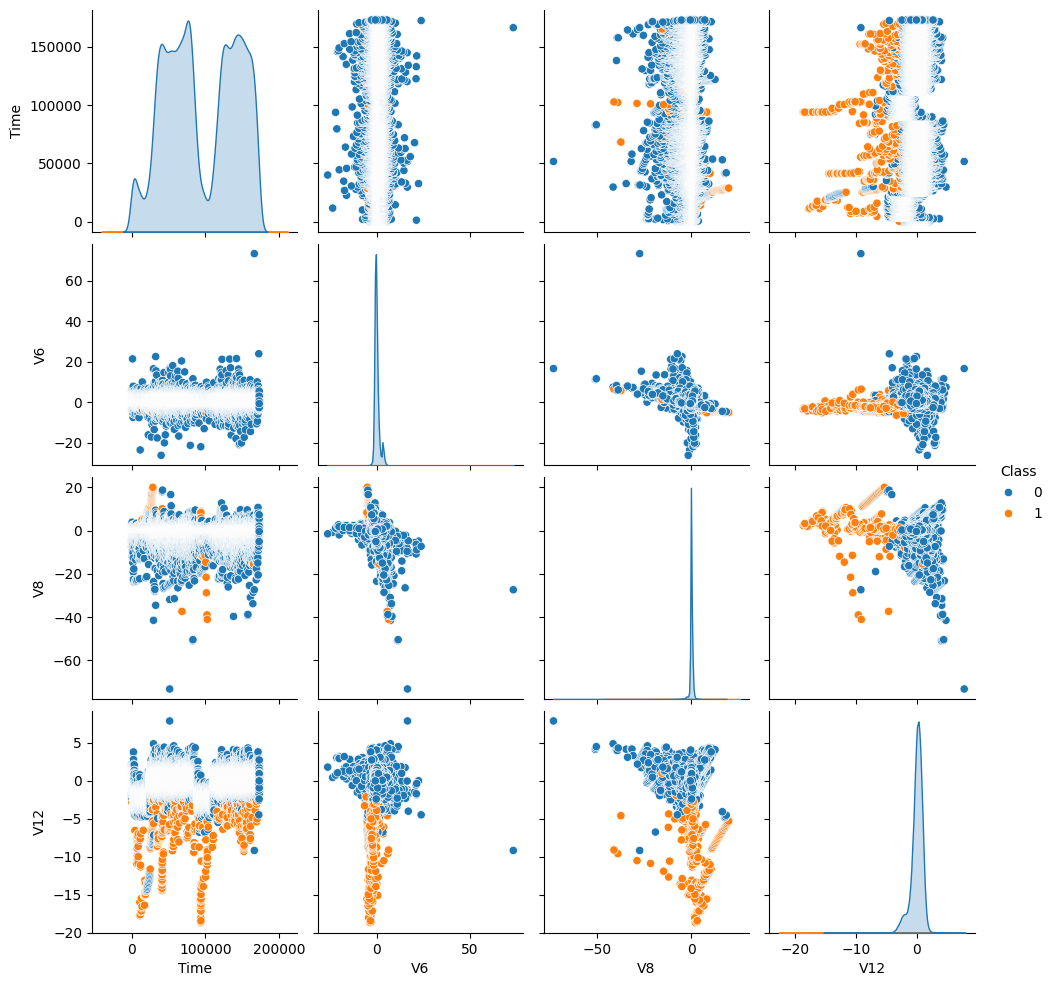

In [18]:
selected_features = ['Time', 'V6', 'V8', 'V12']
data_subset = df[selected_features + ['Class']]
sns.pairplot(data_subset, hue='Class', diag_kind='kde')
plt.show()

Далее будем непосредственно обучать машину. В качестве метода для начала посмотрим на Логистическую регрессию 

In [37]:
X = df.drop(['Class'], axis=1)
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.35, random_state=42)

stratify необходимо для сохранения процента подозрительных операций в тестовой и контрольной выборке

In [38]:
print(round(y_train.value_counts()[1] / y_train.shape[0] * 100, 3))
print(round(y_test.value_counts()[1] / y_test.shape[0] * 100, 3))

0.173
0.173


До 3 знака одинаковые 

In [39]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

нормализуем данные

In [41]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X_train_normalized, y_train)
y_pred = lr.predict(X_test_normalized)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99511
           1       0.07      0.88      0.12       172

    accuracy                           0.98     99683
   macro avg       0.53      0.93      0.56     99683
weighted avg       1.00      0.98      0.99     99683



Как видно метрика precision крайне так себе. 
Только 7% записей из 1 класа модель отобрала корректно, это плохо


Попробуем воспользоавться другим методом для лучшего результата. В качестве метода будем использовать Catboost, должно получиться получше.

In [47]:
cb = CatBoostClassifier()
X = df.drop(['Class'], axis=1)
y = df.Class
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.35, random_state=42)

In [48]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

In [49]:
cb.fit(X_train_normalized, y_train)
y_pred = cb.predict(X_test_normalized)

Learning rate set to 0.09575
0:	learn: 0.3717898	total: 185ms	remaining: 3m 4s
1:	learn: 0.2071481	total: 218ms	remaining: 1m 48s
2:	learn: 0.1143902	total: 248ms	remaining: 1m 22s
3:	learn: 0.0647652	total: 275ms	remaining: 1m 8s
4:	learn: 0.0387386	total: 301ms	remaining: 59.9s
5:	learn: 0.0247551	total: 328ms	remaining: 54.3s
6:	learn: 0.0166304	total: 354ms	remaining: 50.2s
7:	learn: 0.0118072	total: 378ms	remaining: 46.9s
8:	learn: 0.0089621	total: 411ms	remaining: 45.2s
9:	learn: 0.0068687	total: 433ms	remaining: 42.9s
10:	learn: 0.0055689	total: 456ms	remaining: 41s
11:	learn: 0.0047971	total: 481ms	remaining: 39.6s
12:	learn: 0.0041970	total: 507ms	remaining: 38.5s
13:	learn: 0.0038201	total: 530ms	remaining: 37.3s
14:	learn: 0.0034793	total: 555ms	remaining: 36.4s
15:	learn: 0.0032343	total: 578ms	remaining: 35.5s
16:	learn: 0.0030362	total: 600ms	remaining: 34.7s
17:	learn: 0.0028706	total: 630ms	remaining: 34.4s
18:	learn: 0.0027420	total: 653ms	remaining: 33.7s
19:	learn: 0

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.95      0.78      0.86       172

    accuracy                           1.00     99683
   macro avg       0.97      0.89      0.93     99683
weighted avg       1.00      1.00      1.00     99683



Как и ожидалось метрика precision возрасла с 0.07 до 0.95, что можно считать хорошим результатам. (Не зря люди в яндексе работают)